In [1]:
!pip install livelossplot

In [2]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from livelossplot import PlotLossesKeras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isdir, isfile, join

In [3]:
data_dir = '../input/automobilepartsindentification/Automobile-parts'

img_width = 300
img_height = 300

EPOCHS = 20
BATCH_SIZE = 32

IMAGE_SHAPE = (img_width, img_height)


In [4]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.3,
    width_shift_range=0.5,
    brightness_range=[0.1,0.9],
    rotation_range=90,
    validation_split=0.1,
    zoom_range=0.1
)

In [5]:
CLASSES = sorted(listdir(data_dir))
CLASSES

['Bevel-gear',
 'bearing',
 'clutch',
 'cylincer',
 'filter',
 'fuel-tank',
 'helical_gear',
 'piston',
 'rack-pinion',
 'shocker',
 'spark-plug',
 'spur-gear',
 'valve',
 'wheel']

In [6]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = CLASSES,
    subset='training',
    shuffle=True,
    seed=116,
)

validation_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = CLASSES,
    subset='validation',
    shuffle=True,
    seed=116,
)

Found 627 images belonging to 14 classes.
Found 61 images belonging to 14 classes.


In [7]:
model = Sequential()

# base_model
base_model = InceptionV3(include_top=False,input_shape=(img_width, img_height,3))
base_model.trainable=False

model.add(base_model)

#### Fully-Connected Layer ####
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(CLASSES), activation='softmax'))

model.summary()

2022-09-04 03:00:03.188406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 03:00:03.328169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 03:00:03.329090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 03:00:03.330645: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 14)                14350     
Total params: 23,915,310
Trainable params: 2,112,526
Non-trainable params: 21,802,784
_________________________________________________________________


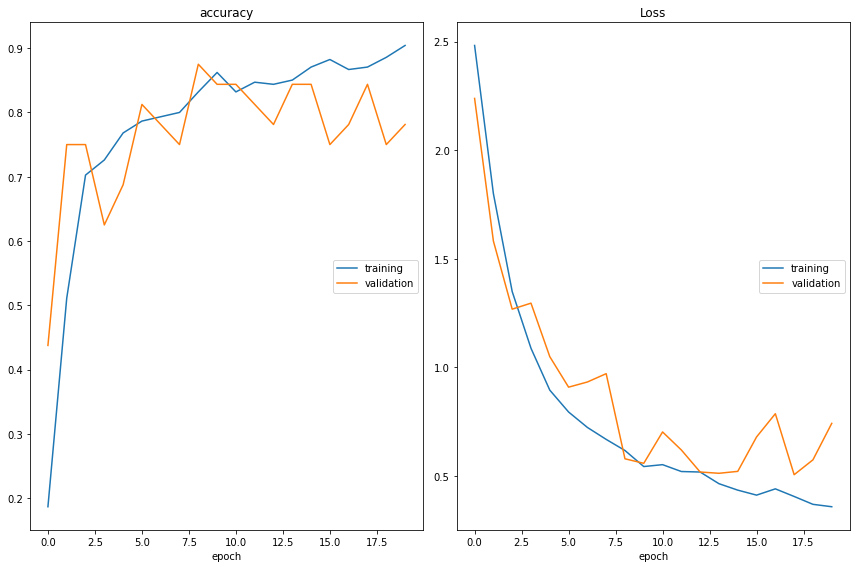

accuracy
	training         	 (min:    0.187, max:    0.904, cur:    0.904)
	validation       	 (min:    0.438, max:    0.875, cur:    0.781)
Loss
	training         	 (min:    0.359, max:    2.482, cur:    0.359)
	validation       	 (min:    0.506, max:    2.238, cur:    0.743)


In [8]:
steps_for_each_epoch = train_gen.samples // BATCH_SIZE
validation_steps_for_each_epoch = validation_gen.samples // BATCH_SIZE

OPTIMIZER = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

## save model after every epoch ##
checkpointer = ModelCheckpoint(filepath='img_model.trained.weights.hdf5', verbose=1, save_best_only=True)

## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

history = model.fit(
    train_gen, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_for_each_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps_for_each_epoch,
    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
    verbose=True
)

In [9]:
test_loss, test_acc = model.evaluate(validation_gen)
print('test accuracy : ', test_acc)


trained_model = load_model('img_model.trained.weights.hdf5')

2/2 [==============================] - 2s 1s/step - loss: 0.5697 - accuracy: 0.8361
test accuracy :  0.8360655903816223


In [10]:
def predict_img(img_path):
    img = image.load_img(data_dir+img_path, target_size=(300, 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = trained_model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',CLASSES[np.argmax(p[0])])
    print("\n")

# This method is not used in this kernal, if running locally you can test the model performance by passing some unseen images to it
def predict_external_img(full_img_path):
    img = image.load_img(full_img_path, target_size=(300, 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = trained_model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',CLASSES[np.argmax(p[0])])


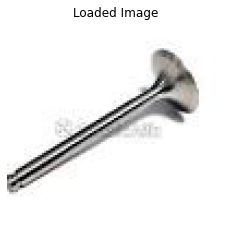

Confidence:  98.74%
Class:  valve




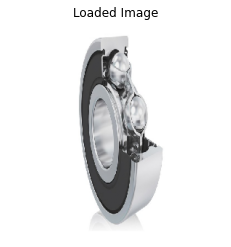

Confidence:  85.0%
Class:  bearing




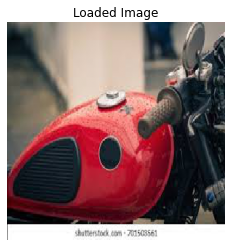

Confidence:  78.14%
Class:  fuel-tank




In [11]:
predict_img('/valve/image (110).jpg')
predict_img('/bearing/image (13).jpg')
predict_img('/fuel-tank/image (13).jpg')

In [12]:
#predict_external_img('/Users/pavanmantha/Pavans/PracticeExamples/DeepLearning_Practice/Automobile_Parts_Classification/external_test_imgs/engine-piston.webp')
#predict_external_img('/Users/pavanmantha/Pavans/PracticeExamples/DeepLearning_Practice/Automobile_Parts_Classification/external_test_imgs/4-cylinders-engine.jpeg')
